In [72]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
stop=nltk.corpus.stopwords.words('english')
from nltk import word_tokenize
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from wordcloud import WordCloud

2023-01-27 12:40:01 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-01-27 12:40:01 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-01-27 12:40:01 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2023-01-27 12:40:01 INFO: Use device: cpu
2023-01-27 12:40:01 INFO: Loading: tokenize
2023-01-27 12:40:01 INFO: Loading: pos
2023-01-27 12:40:01 INFO: Loading: lemma
2023-01-27 12:40:01 INFO: Done loading processors!


In [2]:
data=pd.read_csv('/Volumes/T7/mt-hemingway/data/book_final.csv')
cosine_df=pd.read_csv('/Volumes/T7/mt-hemingway/data/cosine_df.csv')
korean_df=pd.read_csv('/Volumes/T7/mt-hemingway/data/korean_df.csv')

In [9]:
cosine_df.columns

Index(['OPUS_small', 'OPUS_big', 'M2M100_small', 'M2M100_big', 'kakao_small',
       'kakao_big', 'google_small', 'google_big'],
      dtype='object')

In [3]:
print(data.shape, cosine_df.shape, korean_df.shape)

(768, 14) (768, 8) (768, 10)


In [4]:
cosine_df['OPUS_small'].quantile(0.25)

0.5741938054561615

In [25]:
cosine_df['OPUS_big'].quantile(0.25)

0.5943563431501389

In [10]:
def low_quartile(df:pd.DataFrame, small:str, big:str):
    low_quartile_small=df[df[small]<df[small].quantile(0.25)][small].index
    low_quartile_big=df[df[big]<df[big].quantile(0.25)][big].index
    return list(set(low_quartile_small).intersection(set(low_quartile_big)))

In [31]:
def low_quartile_common_small_ratio(low_quartile_list:list, df:pd.DataFrame, small:str):
    low_quartile_small=df[df[small]<df[small].quantile(0.25)][small].index
    return len(low_quartile_list)/len(low_quartile_small)

In [32]:
def low_quartile_common_big_ratio(low_quartile_list:list, df:pd.DataFrame, big:str):
    low_quartile_big=df[df[big]<df[big].quantile(0.25)][big].index
    return len(low_quartile_list)/len(low_quartile_big)

In [15]:
low_quartile_OPUS=low_quartile(cosine_df, 'OPUS_small', 'OPUS_big')
low_quartile_M2M100=low_quartile(cosine_df, 'M2M100_small', 'M2M100_big')
low_quartile_kakao=low_quartile(cosine_df, 'kakao_small', 'kakao_big')
low_quartile_google=low_quartile(cosine_df, 'google_small', 'google_big')

In [41]:
print(low_quartile_common_small_ratio(low_quartile_OPUS, cosine_df, 'OPUS_small'), low_quartile_common_big_ratio(low_quartile_OPUS, cosine_df, 'OPUS_big'))
print(low_quartile_common_small_ratio(low_quartile_M2M100, cosine_df, 'M2M100_small'), low_quartile_common_big_ratio(low_quartile_M2M100, cosine_df, 'M2M100_big'))
print(low_quartile_common_small_ratio(low_quartile_kakao, cosine_df, 'kakao_small'), low_quartile_common_big_ratio(low_quartile_kakao, cosine_df, 'kakao_big'))
print(low_quartile_common_small_ratio(low_quartile_google, cosine_df, 'google_small'), low_quartile_common_big_ratio(low_quartile_google, cosine_df, 'google_big'))

0.546875 0.546875
0.625 0.625
0.5052083333333334 0.5052083333333334
0.9270833333333334 0.9270833333333334


In [42]:
def low_quartile_output(df:pd.DataFrame, low_quartile_list:list, small:str, big:str):
    concat1=df.loc[low_quartile_list]['original']
    concat2=df.loc[low_quartile_list][small]
    concat3=df.loc[low_quartile_list][big]
    quartile_df=pd.concat([concat1, concat2, concat3], axis=1, ignore_index=True)
    quartile_df.columns=['original', small, big]
    return quartile_df

In [45]:
quartile_OPUS=low_quartile_output(data, low_quartile_OPUS, 'OPUS_small', 'OPUS_big')
quartile_M2M100=low_quartile_output(data, low_quartile_M2M100, 'M2M100_small', 'M2M100_big')
quartile_kakao=low_quartile_output(data, low_quartile_kakao, 'kakao_small', 'kakao_big')
quartile_google=low_quartile_output(data, low_quartile_google, 'google_small', 'google_big')

In [10]:
quartile_OPUS.columns[0]+'_'+'stop'

'original_stop'

In [47]:
def lemmatization(df: pd.DataFrame()):
    df[df.columns[0]]=df[df.columns[0]].str.lower()
    df[df.columns[0]+'_'+'stopwods']=df[df.columns[0]].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[df.columns[0]+'_'+'punct']=df[df.columns[0]+'_'+'stopwods'].str.replace('[^\w\s]','')
    df[df.columns[0]+'_'+'lower']=df[df.columns[0]+'_'+'punct'].str.lower()
    df[df.columns[0]+'_'+'lemma']=df[df.columns[0]+'_'+'lower'].apply(lambda x: ([w.lemma for sent in nlp(x).sentences for w in sent.words]))
    # df[df.columns[0]+'_'+'token']=df[df.columns[0]+'_'+'lemma'].apply(word_tokenize)
    df[df.columns[1]]=df[df.columns[1]].str.lower()
    df[df.columns[1]+'_'+'stopwods']=df[df.columns[1]].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[df.columns[1]+'_'+'punct']=df[df.columns[1]+'_'+'stopwods'].str.replace('[^\w\s]','')
    df[df.columns[1]+'_'+'lower']=df[df.columns[1]+'_'+'punct'].str.lower()
    df[df.columns[1]+'_'+'lemma']=df[df.columns[1]+'_'+'lower'].apply(lambda x: ([w.lemma for sent in nlp(x).sentences for w in sent.words]))
    # df[df.columns[1]+'_'+'token']=df[df.columns[1]+'_'+'lemma'].apply(word_tokenize)
    df[df.columns[2]]=df[df.columns[2]].str.lower()
    df[df.columns[2]+'_'+'stopwods']=df[df.columns[2]].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[df.columns[2]+'_'+'punct']=df[df.columns[2]+'_'+'stopwods'].str.replace('[^\w\s]','')
    df[df.columns[2]+'_'+'lower']=df[df.columns[2]+'_'+'punct'].str.lower()
    df[df.columns[2]+'_'+'lemma']=df[df.columns[2]+'_'+'lower'].apply(lambda x: ([w.lemma for sent in nlp(x).sentences for w in sent.words]))
    # df[df.columns[2]+'_'+'token']=df[df.columns[2]+'_'+'lemma'].apply(word_tokenize)
    return df


In [48]:
OPUS_lemma=lemmatization(quartile_OPUS)
M2M100_lemma=lemmatization(quartile_M2M100)
kakao_lemma=lemmatization(quartile_kakao)
google_lemma=lemmatization(quartile_google)

In [71]:
OPUS_lemma.head(1)['original_lemma']

524    [back, stern, turn, left, hand, hold, strain, ...
Name: original_lemma, dtype: object

In [72]:
OPUS_lemma.head(1)['OPUS_small_lemma']

524    [come, stern, force, pull, rope, shoulder, tur...
Name: OPUS_small_lemma, dtype: object

In [73]:
OPUS_lemma.head(1)['OPUS_big_lemma']

524    [old, man, turn, back, stern, grab, shoulder, ...
Name: OPUS_big_lemma, dtype: object

In [81]:
OPUS_lemma['original_lemma'].iloc[0]

['back',
 'stern',
 'turn',
 'left',
 'hand',
 'hold',
 'strain',
 'line',
 'across',
 'shoulder',
 'draw',
 'knife',
 'sheath',
 'right',
 'hand',
 'star',
 'bright',
 'see',
 'dolphin',
 'clearly',
 'push',
 'blade',
 'knife',
 'head',
 'draw',
 'stern',
 'put',
 'one',
 'foot',
 'fish',
 'slit',
 'quickly',
 'vent',
 'tip',
 'low',
 'jaw',
 'put',
 'knife',
 'gut',
 'right',
 'hand',
 'scoop',
 'clean',
 'pull',
 'gill',
 'clear',
 'feel',
 'maw',
 'heavy',
 'slippery',
 'hand',
 'slit',
 'open',
 'two',
 'fly',
 'fish',
 'inside',
 'fresh',
 'hard',
 'laid',
 'side',
 'side',
 'drop',
 'gut',
 'gill',
 'stern',
 'sink',
 'leave',
 'trail',
 'phosphorescence',
 'water',
 'dolphin',
 'cold',
 'leprous',
 'graywhite',
 'starlight',
 'old',
 'man',
 'skinned',
 'one',
 'side',
 'hold',
 'right',
 'foot',
 'fish',
 'head',
 'turn',
 'skinned',
 'side',
 'cut',
 'side',
 'head',
 'tail']

In [92]:
OPUS_lemma.shape[0]

105

In [49]:
def bias(df: pd.DataFrame(), column1: str, column2: str, column3: str):
    not_in_org_count=[]
    for i in range(df.shape[0]):
        org=[x for x in df[column1].iloc[i] if x is not None]
        compare1=[x for x in df[column2].iloc[i] if x is not None]
        compare2=[x for x in df[column3].iloc[i] if x is not None]
        machine_common=pd.Series(np.intersect1d(compare1, compare2))
        org_common=pd.Series(np.intersect1d(org, machine_common))
        not_in_org=list(set(machine_common)-set(org_common))
        for element in not_in_org:
            not_in_org_count.append(element)
    return not_in_org_count

In [52]:
OPUS_bias=bias(OPUS_lemma, 'original_lemma', 'OPUS_small_lemma', 'OPUS_big_lemma')
M2M100_bias=bias(M2M100_lemma, 'original_lemma', 'M2M100_small_lemma', 'M2M100_big_lemma')
kakao_bias=bias(kakao_lemma, 'original_lemma', 'kakao_small_lemma', 'kakao_big_lemma')
google_bias=bias(google_lemma, 'original_lemma', 'google_small_lemma', 'google_big_lemma')

In [71]:
Counter(OPUS_bias).most_common(10)

[('man', 13),
 ('old', 13),
 ('go', 7),
 ('meat', 4),
 ('fishing', 3),
 ('back', 3),
 ('still', 3),
 ('be', 3),
 ('feel', 3),
 ('yes', 2)]

In [70]:
Counter(M2M100_bias).most_common(10)

[('man', 21),
 ('old', 17),
 ('go', 13),
 ('meat', 13),
 ('fishing', 8),
 ('get', 5),
 ('boat', 5),
 ('would', 5),
 ('sea', 5),
 ('mouse', 5)]

In [69]:
Counter(kakao_bias).most_common(10)

[('man', 9),
 ('old', 8),
 ('still', 5),
 ('get', 4),
 ('run', 4),
 ('big', 3),
 ('catch', 3),
 ('meat', 3),
 ('feel', 3),
 ('sea', 3)]

In [68]:
Counter(google_bias).most_common(10)

[('man', 61),
 ('old', 61),
 ('meat', 29),
 ('fishing', 17),
 ('I', 15),
 ('it', 14),
 ('go', 13),
 ('like', 12),
 ('guy', 12),
 ('time', 11)]

In [63]:
wc_OPUS=WordCloud(collocations=False, background_color='white').generate(' '.join(OPUS_bias))
wc_M2M100=WordCloud(collocations=False, background_color='white').generate(' '.join(M2M100_bias))
wc_kakao=WordCloud(collocations=False, background_color='white').generate(' '.join(kakao_bias))
wc_google=WordCloud(collocations=False, background_color='white').generate(' '.join(google_bias))

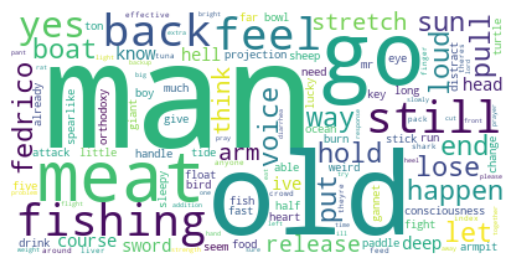

In [64]:
plt.imshow(wc_OPUS, interpolation='bilinear')
plt.axis('off')
plt.show()

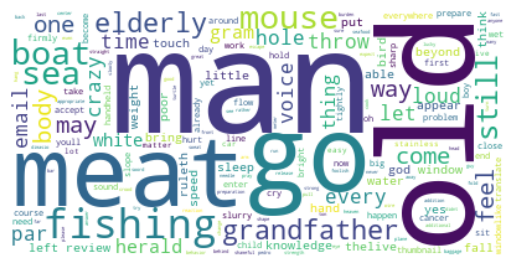

In [65]:
plt.imshow(wc_M2M100, interpolation='bilinear')
plt.axis('off')
plt.show()

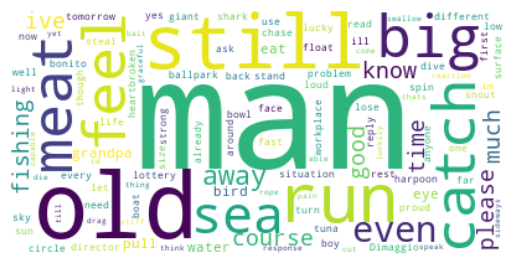

In [66]:
plt.imshow(wc_kakao, interpolation='bilinear')
plt.axis('off')
plt.show()

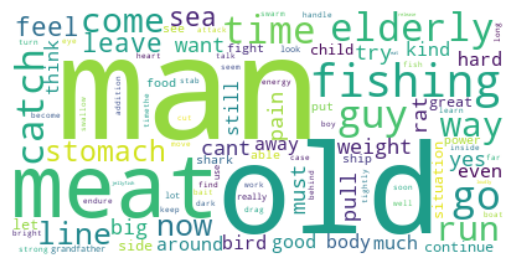

In [67]:
plt.imshow(wc_google, interpolation='bilinear')
plt.axis('off')
plt.show()